## Here will be analysis for the first Time Since Infection Paper

#### I will include both the mouse and the monkey analyses here.

### Mouse Analysis

#### Install required packages as needed
- Not all of these installed, but it should be fine for my purposes, I hope
- If note, this github has procedures for making sure R CRAN packages get installed into conda: https://github.com/conda/conda/issues/4355
https://stackoverflow.com/questions/34705917/conda-how-to-install-r-packages-that-are-not-available-in-r-essentials

In [ ]:
# This is the correct way, that I learned in initially doing Monkey analysis in jupyter notebooks
# If I need to update packages, I may need to unlock these packages, as I can't reinstall caret with this code
#conda.r = "/master/rault/miniconda3/lib/R/library"
#install.packages("caret", conda.r)

#install.packages("deepnet", conda.r)
#devtools::install_github('topepo/caret/pkg/caret')
#install.packages("ranger", conda.r)
#install.packages("glmnet", conda.r)
#install.packages("gbm", conda.r)
#install.packages("e1071", conda.r)
#install.packages("mlbench", conda.r)

In [2]:
#source("https://bioconductor.org/biocLite.R")
#biocLite()
#biocLite("Biobase")
# biocLite("GEOquery")
# biocLite("limma")
# biocLite("multtest")
# biocLite("HybridMTest")
# biocLite("MLInterfaces")
# install.packages("scatterplot3d")
# install.packages("rgl")
# install.packages("pheatmap")
# install.packages("dplyr")
# install.packages("gplots")
# install.packages("class")
# install.packages("e1071")
# install.packages("heatmap3")
# install.packages("heatmap.plus")
# install.packages("randomForest")
# install.packages("caret")

#### Load Required Libraries

Loading all the below works, except rgl and MLInterfaces, which I should not need

In [ ]:
#library("randomForest")
#library(gplots)
#require("heatmap.plus")
#require("heatmap3")
#library(Biobase)
#library(GEOquery)
#library(limma)
#library(scatterplot3d)
#library(rgl)
#library(multtest)
#library(pheatmap)
#library(HybridMTest)
#library(class)
#library(MLInterfaces)
#library(e1071)
#library(caret)
#library(repr)
#require(dplyr) # I don't think this is needed absolutely currently

In [1]:
if (!require("preprocessCore")) {
  source("https://bioconductor.org/biocLite.R")
  biocLite("preprocessCore")
  library("preprocessCore")
}
if (!require("GGally")) {
    install.packages("GGally")
    library("GGally")
}
library(ggplot2)
library(randomForest)
library(Biobase)
library(GEOquery)

Loading required package: preprocessCore
Loading required package: GGally
randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:randomForest’:

    combine

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengt

In [4]:
# Make R graphs smaller
options(repr.plot.width=4, repr.plot.height=3)

#### Set up the environment and load in the data, applying p value of detection to whole dataset with all strains

In [5]:
source("utils.R")
path  = "/master/rault/TB"
data_path = paste(path, "/data/Mouse", sep="")

In [6]:
array_data = read.delim(paste(data_path, "P13_2011DS114_9MouseChips_BM_V4_0_R1_21Jan2011_Norm.txt", sep="/"))
QC_data = read.delim(paste(data_path,"P13_2011DS114_9MouseChips_BM_V4_0_R1_21Jan2011_QC.txt", sep="/"), header=T, skip = 8)
RNA_QC = read.delim(paste(data_path,"P13_TB_Mice_RNA QC.txt", sep="/"), header=T)
mousechip_conv = read.delim(paste(data_path,"Mousechip.txt", sep="/"), header=T)
pheno_data = read.delim(paste(data_path,"BV microarray for Baylor Annotation_Clinical.txt", sep="/"), header=T)

In [9]:
colnames(pheno_data)[1] = "Sample.Group"
pheno_data$chip.name = paste("M#", pheno_data$Donor.ID, "OSU", sep="")

In [10]:
eset = make.expression.set(array_data, pheno_data, mousechip_conv)
eset

ExpressionSet (storageMode: lockedEnvironment)
assayData: 17275 features, 50 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: M#11OSU M#12OSU ... M#72OSU (50 total)
  varLabels: Strain Infect.Status Time.point.days
  varMetadata: M#11OSU M#12OSU ... labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

#### Select only C57BL/6 mice and quantile normalize their arrays

Warning message in boxplot(log2(exprs(eset.B6) + 1), ylim = c(4, 10)):
“NaNs produced”

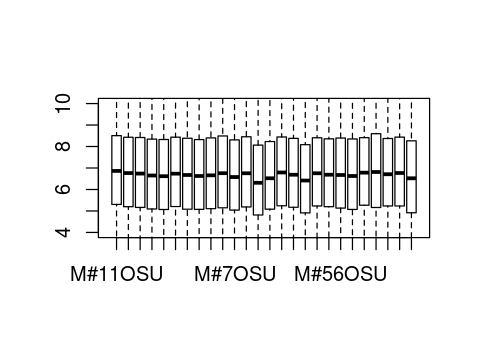

In [12]:
eset.B6 = eset[, eset$Strain=="C57BL/6"]
boxplot(log2(exprs(eset.B6) + 1), ylim=c(4,10))

Warning message in boxplot(log2(exprs(qn) + 1), ylim = c(4, 10)):
“NaNs produced”

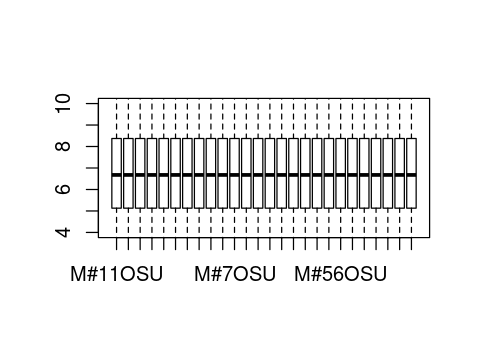

In [13]:
qn = eset.B6
exprs(qn) = normalize.quantiles(exprs(eset.B6))
boxplot(log2(exprs(qn)+1), ylim = c(4, 10))

In [64]:
# To do percentile normalization, may want to multiply by a ratio to get back to original scale for later functions, or just do everything on log scale

#per75 = apply(exprs(eset.B6.med), 2, quantile, 0.50)
#exprs(eset.B6.med) <- sweep(exprs(eset.B6.med), 2, per75, "/" )
#boxplot(exprs(eset.B6.med), ylim = c(0, 2))

#### Now find genes that are 2-fold changed from median in 10% of samples (basic filtering) and log2 transform the data

In [14]:
eset.B6.2xUDALO = normalization(qn)
exprs(eset.B6.2xUDALO) = log2(exprs(eset.B6.2xUDALO) + 1)
#boxplot(exprs(eset.B6.2xUDALO), ylim = c(4,10))   # Now not perfectly distributed because we filtered the variable genes

[1] "1717 genes passed the 2 fold change from median in 10% of samples filter"


#### We now have the detected genes from all mice and variable genes within the C57BL/6 mice 
#### Now do PCA and graph the results by M.tb infection status and time point.

In [20]:
PCA.B6 = prcomp(t(exprs(eset.B6.2xUDALO)), scale.=T)

In [21]:
gg.PCA.B6.inf = as.data.frame(PCA.B6$x[,1:5])
gg.PCA.B6.days = gg.PCA.B6.inf
gg.PCA.B6.inf$Infect.Status = eset.B6.2xUDALO$Infect.Status
gg.PCA.B6.days$Time.point.days = as.character(eset.B6.2xUDALO$Time.point.days)



#data.frame(PCA.B6$x[,1:2], Infect.Status=eset.B6.2xUDALO$Infect.Status)

##### In the dataset of all C57BL/6 mice, the first principle component clearly separates infected from uninfected mice. No other principle component separates these groups

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


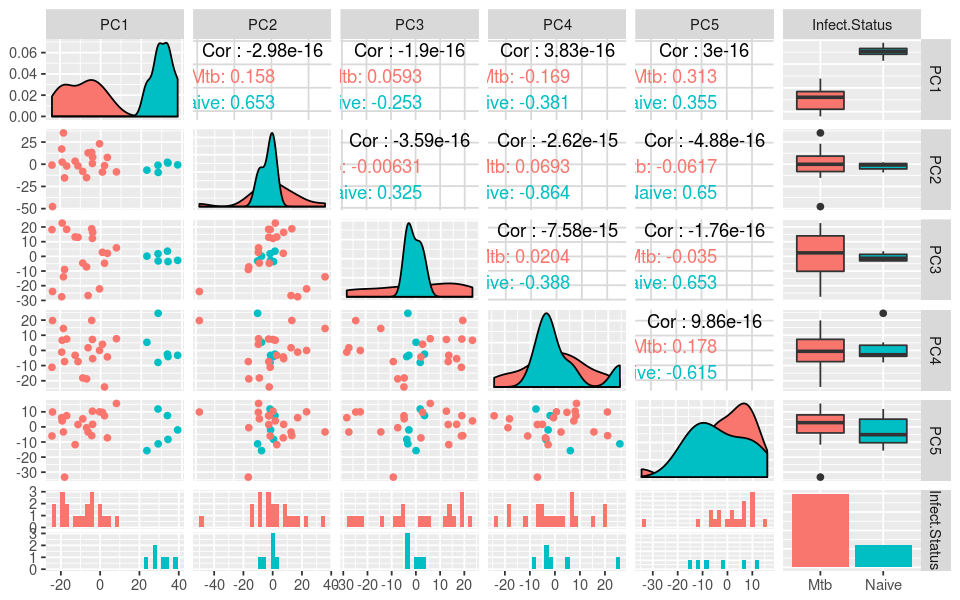

In [22]:
options(repr.plot.width=8, repr.plot.height=5)
print(ggpairs(gg.PCA.B6.inf, aes(colour = Infect.Status)))

##### This graph tells me that a combination of PCA1 and PCA3 separates the time periods in C57BL/6 mice. MaybeI should do a PCA only in infected mice too to show this point. Groups of 3 of all time points cluster alone on this plot, suggesting leave 1-out cross-validation could give better prediction, but I will keep 3-fold to not overfit.
- Also I think base R will make a better, cleaner figure for publication. But this package works very well for visualization.
- I think I could have 2 separate figures in Figure 1, one to show that all the infect and uninfect are different. One to show the time points within the infected group.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


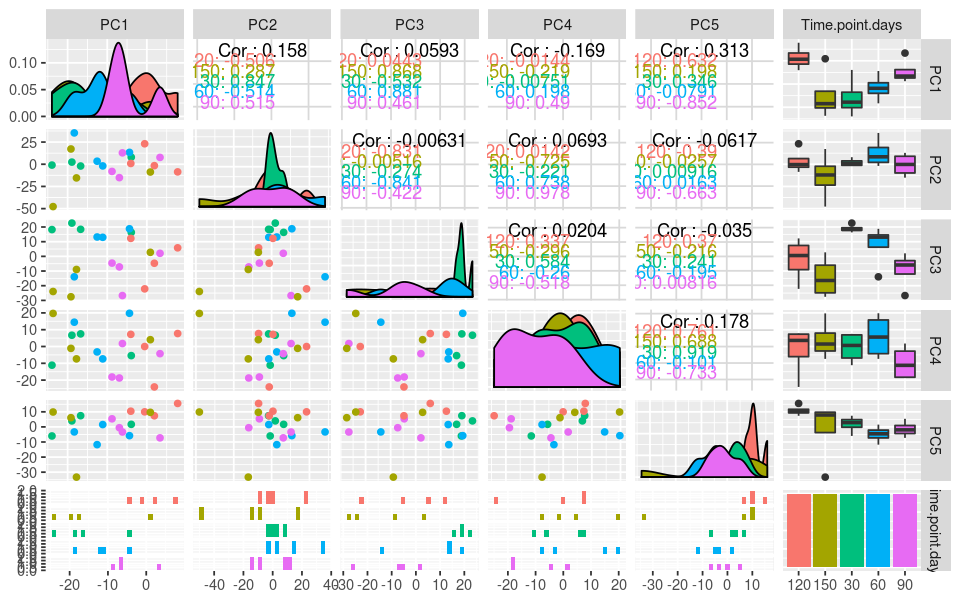

In [23]:
options(repr.plot.width=8, repr.plot.height=5)
gg.PCA.B6.Mtb = gg.PCA.B6.days[eset.B6.2xUDALO$Infect.Status == "Mtb",]
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Time.point.days)))

##### Here is PCA only in Infected mice, to visualize the time point separations without the effect of infection. Here a combination of principle component 1 & 2 separate these time points, with principle component 1 doing most of the separation. Therefore, time point explains most of the variation of the data within M.tb infected mice

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


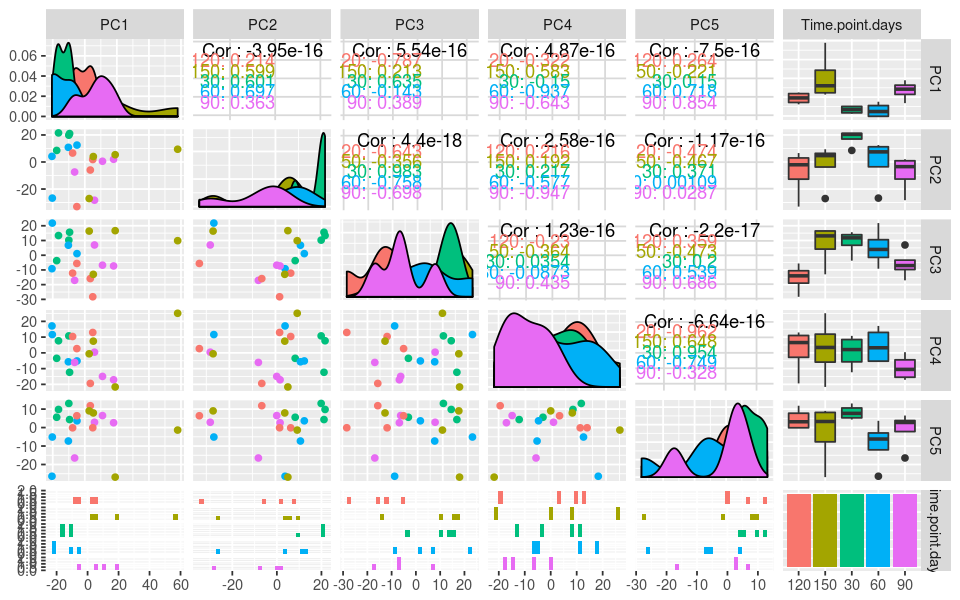

In [24]:
eset.B6.Mtb = eset.B6.2xUDALO[,eset.B6.2xUDALO$Infect.Status == "Mtb"]
PCA.B6.Mtb = prcomp(t(exprs(eset.B6.Mtb)), scale.=T)
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Time.point.days = as.character(eset.B6.Mtb$Time.point.days)
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Time.point.days)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


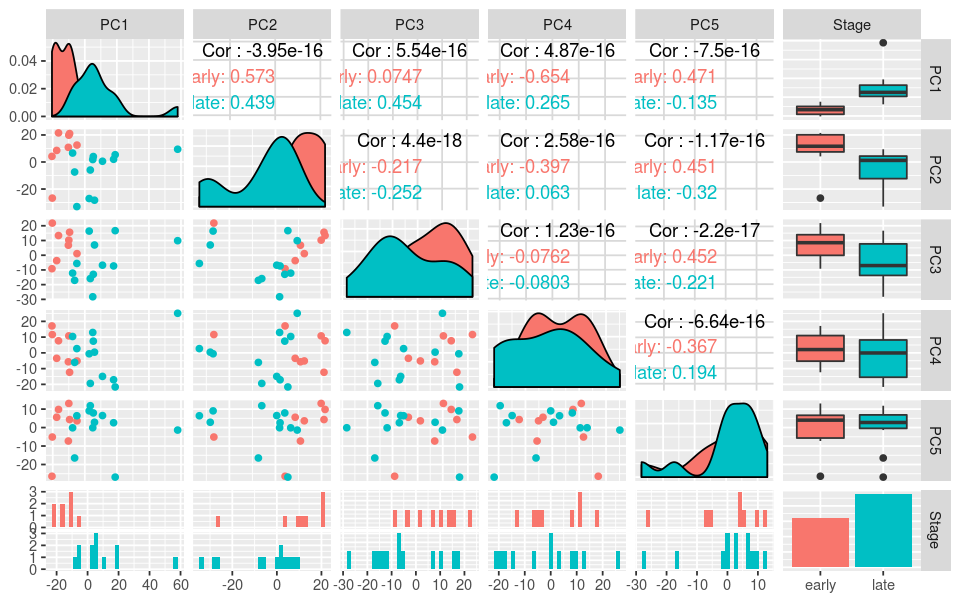

In [25]:
stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Stage = stage
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Stage)))

#### Exploratory PCA showed that the 2 major sources of variation in the data are 1) Whether mice were infected and 2) Were mice infected for 1-2 mo. vs. 3-5 mo. Now I will make the PCA graphs for Figure 1 of the paper, focusing on these two points

#### I will worry about putting the two plots into a nice figure later, after the machine learning

In [ ]:
eset.B6.Mtb = eset.B6.2xUDALO[,eset.B6.2xUDALO$Infect.Status == "Mtb"]
PCA.B6.Mtb = prcomp(t(exprs(eset.B6.Mtb)), scale.=T)
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Time.point.days = as.character(eset.B6.Mtb$Time.point.days)
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Time.point.days)))
stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")
gg.PCA.B6.Mtb = as.data.frame(PCA.B6.Mtb$x[,1:5])
gg.PCA.B6.Mtb$Stage = stage
print(ggpairs(gg.PCA.B6.Mtb, aes(colour = Stage)))

In [91]:
#summary(PCA.B6.Mtb)
#PCA.B6.Mtb

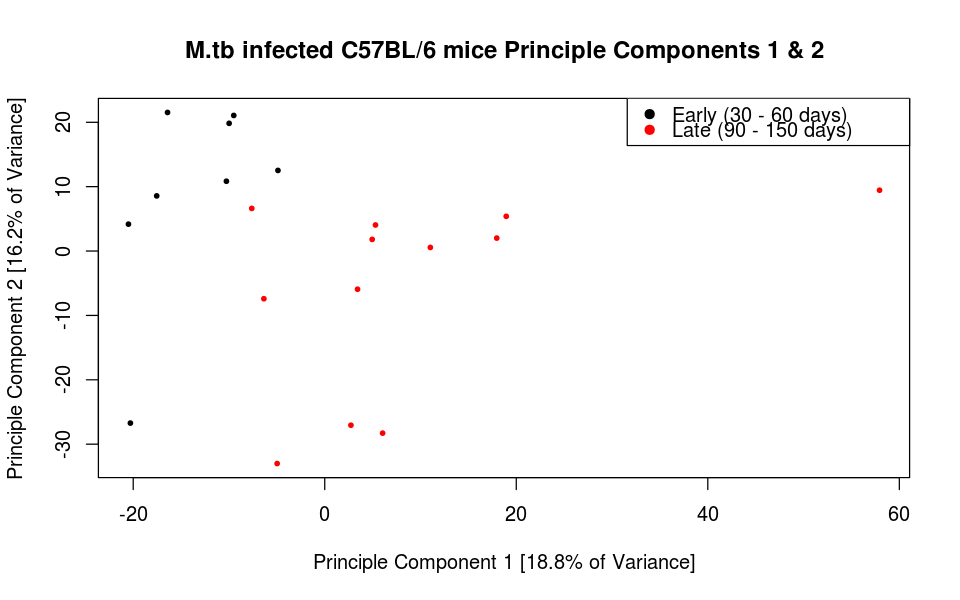

In [50]:
# Still need to put in the variance explained and also separate the legend a little. Ggplot might honestly give a better equivalent 
eset.B6.Mtb = eset.B6.2xUDALO[,eset.B6.2xUDALO$Infect.Status == "Mtb"]
PCA.B6.Mtb = prcomp(t(exprs(eset.B6.Mtb)), scale.=T)

std_dev = PCA.B6.Mtb$sdev
pr_var = std_dev^2
prop_varex = pr_var / sum(pr_var)

stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")

plot(PCA.B6.Mtb$x[,"PC1"], PCA.B6.Mtb$x[,"PC2"], pch=19,
    cex=0.5, col=as.factor(stage),
     xlab=paste("Principle Component 1 [", format(prop_varex[1]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     ylab=paste("Principle Component 2 [", format(prop_varex[2]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     main="M.tb infected C57BL/6 mice Principle Components 1 & 2")
legend("topright", legend=c('Early (30 - 60 days)', 'Late (90 - 150 days)'), col=c("black", "red"), pch=19)

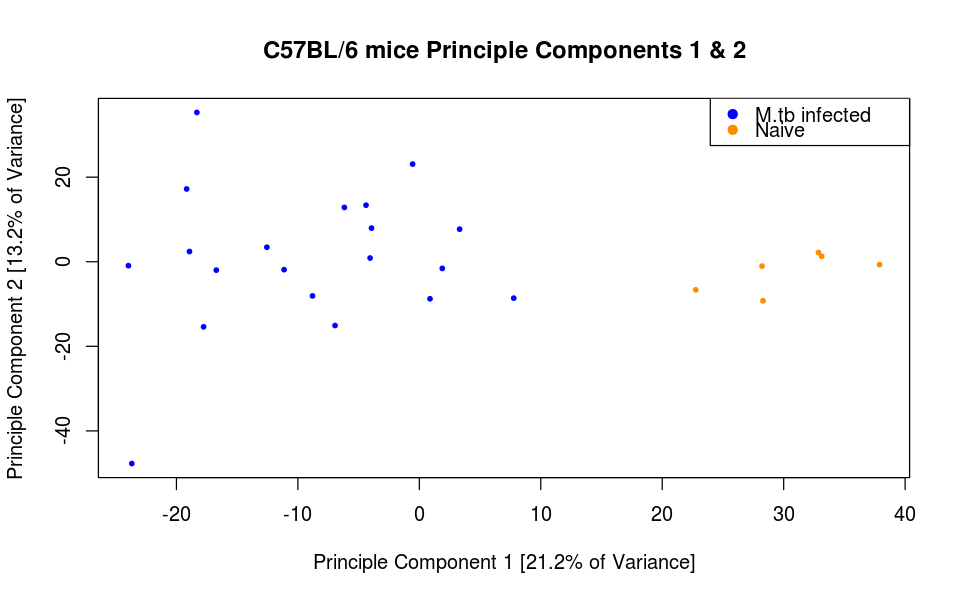

In [52]:

std_dev = PCA.B6$sdev
pr_var = std_dev^2
prop_varex = pr_var / sum(pr_var)

plot(gg.PCA.B6.inf$PC1, gg.PCA.B6.inf$PC2, pch=19,
     cex=0.5, col=ifelse(gg.PCA.B6.inf$Infect.Status=="Mtb", "blue", "darkorange"),
     xlab=paste("Principle Component 1 [", format(prop_varex[1]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     ylab=paste("Principle Component 2 [", format(prop_varex[2]*100, digits=3, nsmall=1), "% of Variance]", sep=""),
     main="C57BL/6 mice Principle Components 1 & 2")
legend("topright", legend=c('M.tb infected', 'Naive'), col=c("blue", "darkorange"), pch=19)

##### The code below is from one of my BMI 8050 homeworks, demonstrating plotting of PCA data

In [ ]:
plot(PCA.B6.Mtb$x[,"PC1"], PCA.B6.Mtb$x[,"PC2"], pch=19,
    cex=0.5, col=PCA.B6.Mtb$,
     xlab="Principle Component 1",
     ylab="Principle Component 2",
     main="M.tb infected C57BL/6 mice Principle Components 1 & 2")

In [ ]:
# 3 (b) Plot the cancer samples according to the first two principle components and visually cluster the data

df = data.frame(x=tcga_PCA$x[,"PC1"], y=tcga_PCA$x[,"PC2"])
commonTheme = list(labs(color="Density",fill="Density",
                        x="Principle Component 1",
                        y="Principle Component 2"),
                   theme_bw(),
                   theme(legend.position=c(0,1),
                         legend.justification=c(0,1)))

ggplot(data=df,aes(x,y)) + 
  geom_density2d(aes(colour=..level..)) + 
  scale_colour_gradient(low="green",high="red") + 
  geom_point() + commonTheme + ggtitle("Density Contour Map of Breast Cancer Samples by Principle Components 1 & 2")

In [ ]:
plot(tcga_PCA$x[,"PC1"], tcga_PCA$x[,"PC2"], pch=19, 
     cex=0.5, col=ifelse(tcga_PCA$x[,"PC1"] < my_cutoff, "blue", "red"),
     xlab="Principle Component 1",
     ylab="Principle Component 2",
     main="Breast Cancer Samples along Principle Components 1 & 2") 
legend("topright", legend=c('My cluster 1', 'My cluster 2'), col=c("blue", "red"), pch=19)

#### Now do Random Forests Classification and Regression on the C57BL/6 infected Mouse data

##### Classification

In [81]:
set.seed(100)
stage = ifelse(eset.B6.Mtb$Time.point.days <= 60,
               "early",
               "late")

B6.table.class = as.data.frame(t(exprs(eset.B6.Mtb)))
B6.table.class$stage = as.factor(stage)
B6.rf.class = randomForest(stage~., data=B6.table.class)

I should potentially do more work to make the table prettier and to make sure whether predictions are on the x or y axis of the table, but this result perfectly replicates what I have seen before, so I'm perfectly fine with it.

I'll have to dig more into the details when I analyze feature importance, etc.

In [82]:
B6.rf.class


Call:
 randomForest(formula = stage ~ ., data = B6.table.class) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 41

        OOB estimate of  error rate: 10%
Confusion matrix:
      early late class.error
early     7    1  0.12500000
late      1   11  0.08333333

##### Regression - the result is more dramatic with the filtering I did solely within B6 mice. Maybe filtering within only infected mice could improve results even further?
- I may need to do a transformation of the predictions to get them into a better scale
- What about doing the 5-way classification too? Could that help confirm what I am seeing?

In [83]:
# Great website for tutorial in random forests for tuning 
# http://machinelearningmastery.com/tune-machine-learning-algorithms-in-r/
B6.table.regress = as.data.frame(t(exprs(eset.B6.Mtb)))
B6.table.regress$Time.point.days = eset.B6.Mtb$Time.point.days
#C57.table = make.data.frame(exprs(C57.el.eset), C57.el.eset$Time.point.days, 
#                            "Time.point.days")
B6.table.class5 = B6.table.regress
B6.table.class5$Time.point.days = as.factor(B6.table.regress$Time.point.days)
#summary(exprs(C57.el.eset)[3,])
#summary(C57.table[,4])

#summary(C57.table[,])

In [84]:
set.seed(100)
B6.rf.class5 = randomForest(Time.point.days~., data=B6.table.class5)
B6.rf.class5


Call:
 randomForest(formula = Time.point.days ~ ., data = B6.table.class5) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 41

        OOB estimate of  error rate: 75%
Confusion matrix:
    30 60 90 120 150 class.error
30   3  1  0   0   0        0.25
60   3  1  0   0   0        0.75
90   0  0  0   2   2        1.00
120  0  0  3   1   0        0.75
150  0  0  3   1   0        1.00

In [85]:
set.seed(100)
C57.rf.regres = randomForest(Time.point.days~., data=B6.table.regress)

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”

In [86]:
str(C57.rf.regres)

List of 18
 $ call           : language randomForest(formula = Time.point.days ~ ., data = B6.table.regress)
 $ type           : chr "regression"
 $ predicted      : Named num [1:20] 58.2 69.3 58.3 63.3 69 ...
  ..- attr(*, "names")= chr [1:20] "M#23OSU" "M#24OSU" "M#25OSU" "M#26OSU" ...
 $ mse            : num [1:500] 1350 1491 1360 1003 851 ...
 $ rsq            : num [1:500] 0.25 0.172 0.245 0.443 0.527 ...
 $ oob.times      : int [1:20] 193 178 182 172 189 187 167 166 182 181 ...
 $ importance     : num [1:1717, 1] 43.74 9.62 47.61 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:1717] "ILMN_2543688" "ILMN_2435996" "ILMN_2480021" "ILMN_2734484" ...
  .. ..$ : chr "IncNodePurity"
 $ importanceSD   : NULL
 $ localImportance: NULL
 $ proximity      : NULL
 $ ntree          : num 500
 $ mtry           : num 572
 $ forest         :List of 11
  ..$ ndbigtree    : int [1:500] 9 9 7 9 7 9 9 7 9 7 ...
  ..$ nodestatus   : int [1:11, 1:500] -3 -3 -3 -1 -3 -1 -1 -1 -1 0 ...
  ..$

M#23OSU   M#24OSU   M#25OSU   M#26OSU    M#7OSU   M#32OSU   M#35OSU   M#36OSU 
 58.23057  69.25562  58.27473  63.30523  68.97619  73.54813  81.82335  75.65361 
   M#8OSU   M#43OSU   M#47OSU   M#48OSU   M#55OSU   M#56OSU   M#57OSU   M#58OSU 
113.24451 115.25967  96.65556 112.77714 109.00588 112.12500  82.42896 101.38564 
  M#10OSU   M#66OSU   M#67OSU   M#69OSU 
109.14368  98.16149 107.34359  86.98098

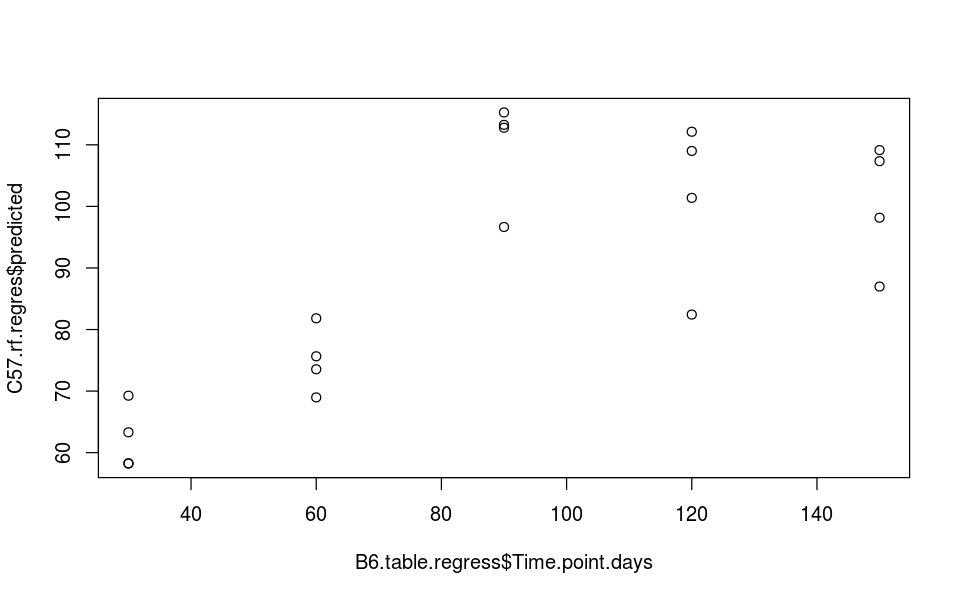

In [87]:
C57.rf.regres$predicted
plot(B6.table.regress$Time.point.days, C57.rf.regres$predicted)

In [88]:
predictions = data.frame(C57.predicted=C57.rf.regres$predicted, C57.Time.point.days = B6.table.regress$Time.point.days)
q = qplot(C57.Time.point.days, C57.predicted, data= predictions, geom = c("point", "smooth"), method="loess")

Warning message:
“Ignoring unknown parameters: method”

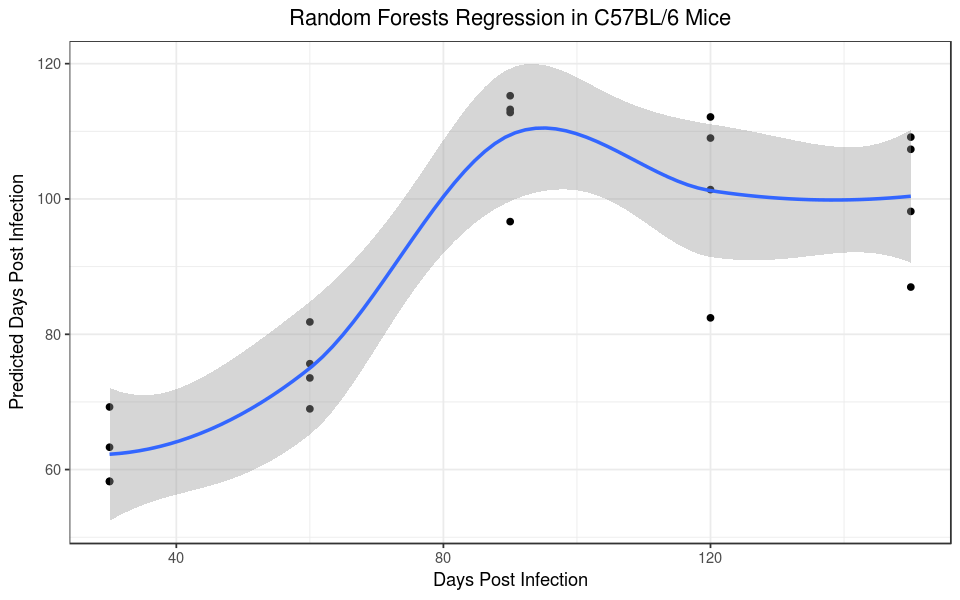

In [89]:
q + theme_bw() + 
  labs(x="Days Post Infection", y="Predicted Days Post Infection") + 
  ggtitle("Random Forests Regression in C57BL/6 Mice") +
  theme(plot.title = element_text(hjust = 0.5))

In [90]:
reg.graph.f = "Random Forests Regression of Time pi in C57BL-6 mice_29Aug2017.pdf"
pdf(reg.graph.f, width=7, height=5)
q + theme_bw() + 
  labs(x="Days Post Infection", y="Predicted Days Post Infection") + 
  ggtitle("Random Forests Regression in C57BL/6 Mice") +
  theme(plot.title = element_text(hjust = 0.5))
dev.off()

png 
  2

### Monkey Analysis

#### Load additional required libraries

In [1]:
source("https://bioconductor.org/biocLite.R")
if (!require(Biobase)) {
  biocLite("Biobase")
  library(Biobase)
}
if (!require(GEOquery)) {
  biocLite("GEOquery")
  library(GEOquery)
}

if (!require(sva)) {
  biocLite("sva")
  library(sva)
}

if (!require(randomForest)) {
  install.packages("randomForest")
  library(randomForest)
}

if (!require(ggplot2)) {
  install.packages("ggplot2")
  library(ggplot2)
}

if (!require("glmnet")) {
  install.packages("glmnet")
  library("glmnet")
}

if (!require("GGally")) {
  install.packages("GGally")
  library("GGally")
}
if (!require("caret")) {
  install.packages("caret")
  library("caret")
}

Bioconductor version 3.6 (BiocInstaller 1.28.0), ?biocLite for help
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.

#### Load data with batch correction and variable gene selection already performed

In [6]:
source("utils.R")
path  = "/master/rault/TB"
monkey_path = paste(path, "/data/Gideon_et_al_Monkey_Data", sep="")

In [7]:
# b_corr_monkey = read.table(file=paste(monkey_path, "ExpressionData_batchedall.txt", sep="/"), header=T, sep="\t")
monkey_var_genes = read.table(file=paste(monkey_path, "ExpressionData_batchcorrected_variablegenes.txt", sep="/"), header=T, sep="\t")
pheno = read.table(file = paste(monkey_path, "PhenoData_filtered.txt", sep="/"), header=T, sep="\t")

In [14]:
pheno$time.period = as.factor(ifelse(pheno$time.point < 3,
                               "pre.infect",
                               ifelse(pheno$time.point <= 10,
                                      "early", 
                                      ifelse(pheno$time.point >= 90,
                                             "late",
                                             "middle"))))

#### Perform PCA and explore separation of time periods and points graphically

In [15]:
PCA.monkey = prcomp(t(monkey_var_genes), scale.=T)

In [16]:
gg.PCA.monkey.period = as.data.frame(PCA.monkey$x[,1:5])
gg.PCA.monkey.period$time.period = pheno$time.period
gg.PCA.monkey.period$time.period = as.character(gg.PCA.monkey.period$time.period)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


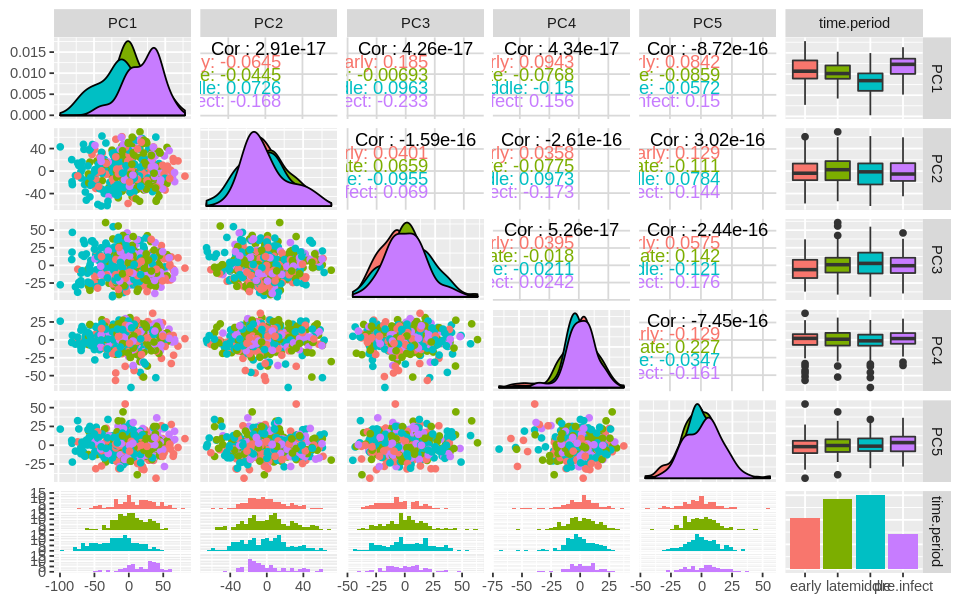

In [18]:
options(repr.plot.width=8, repr.plot.height=5)
print(ggpairs(gg.PCA.monkey.period, aes(colour = time.period)))


#data.frame(PCA.B6$x[,1:2], Infect.Status=eset.B6.2xUDALO$Infect.Status)

##### Now we will do PCA with only the infected groups, and then only the middle and late time point

In [19]:
m_infected = monkey_var_genes[, pheno$time.period != "pre.infect"]
m_middle_late = monkey_var_genes[, pheno$time.period %in% c("middle", "late")]
PCA.monkey_infect = prcomp(t(m_infected ), scale.=T)
PCA.monkey_middle_late = prcomp(t(m_middle_late ), scale.=T)

##### PCA of all time periods post-infection

In [20]:
gg.PCA.monkey.infect = as.data.frame(PCA.monkey_infect$x[,1:5])
gg.PCA.monkey.infect$time.period = pheno[pheno$time.period != "pre.infect",]$time.period
gg.PCA.monkey.infect$time.period = as.character(gg.PCA.monkey.infect$time.period)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


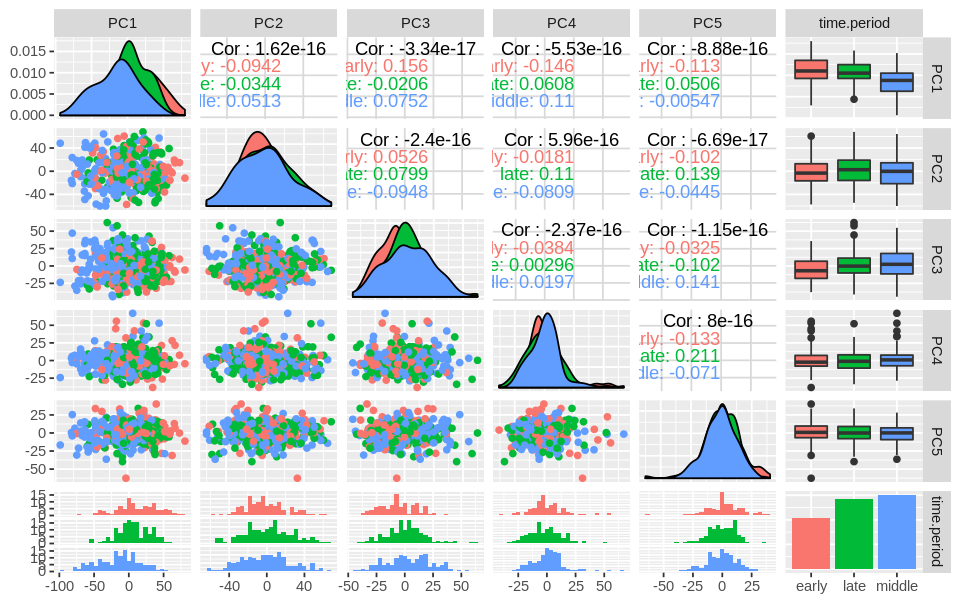

In [21]:
print(ggpairs(gg.PCA.monkey.infect, aes(colour = time.period)))

##### PCA of middle and late time periods post-infection

In [22]:
gg.PCA.monkey.m_l = as.data.frame(PCA.monkey_middle_late$x[,1:5])
gg.PCA.monkey.m_l$time.period = pheno[pheno$time.period  %in% c("middle", "late"),]$time.period
gg.PCA.monkey.m_l$time.period = as.character(gg.PCA.monkey.m_l$time.period)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


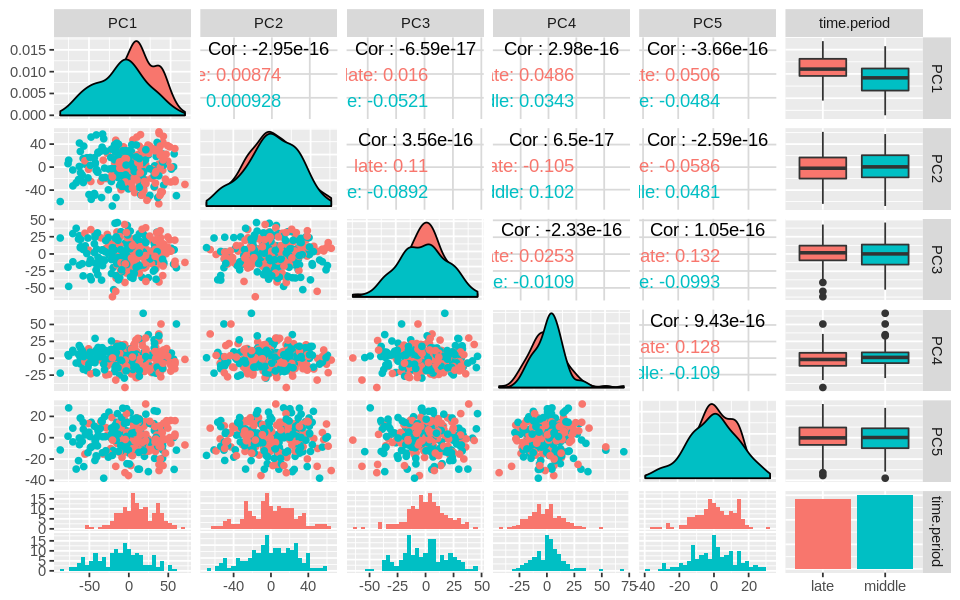

In [23]:
print(ggpairs(gg.PCA.monkey.m_l, aes(colour = time.period)))

##### PCA of all time points within middle and late periods post infection

Result: One can see that days 20, 30 and 42 are the most distinct on PC-1 from all middle and late time periods, and time point 30 is also distinct from the entire dataset (just middle and late set) along PC-3.

In [25]:
gg.PCA.monkey.m_l.point = as.data.frame(PCA.monkey_middle_late$x[,1:5])
gg.PCA.monkey.m_l.point$time.point = pheno[pheno$time.period  %in% c("middle", "late"),]$time.point
gg.PCA.monkey.m_l.point$time.point = as.character(gg.PCA.monkey.m_l.point$time.point)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


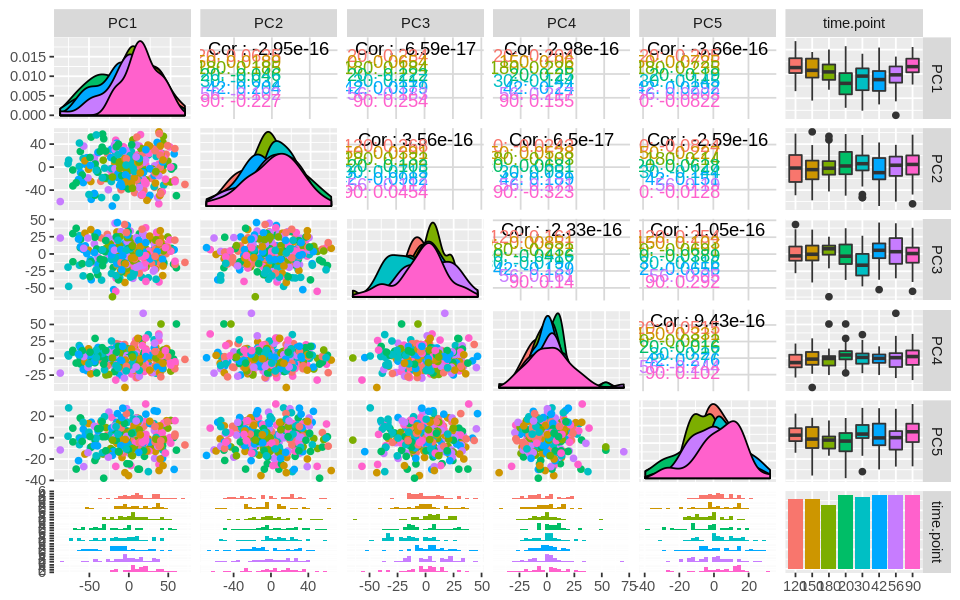

In [26]:
print(ggpairs(gg.PCA.monkey.m_l.point, aes(colour = time.point)))

#### Perform PCA and explore separation of active vs. latent disease across time periods post infection

##### PCA of all time periods with active vs latent

Result: Basically no difference between active vs. latent monkeys along PC-1-5 when looking at the entire dataset.

In [31]:
gg.PCA.monkey.disease = as.data.frame(PCA.monkey$x[,1:5])
gg.PCA.monkey.disease$clinical.status = pheno$clinical.status

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


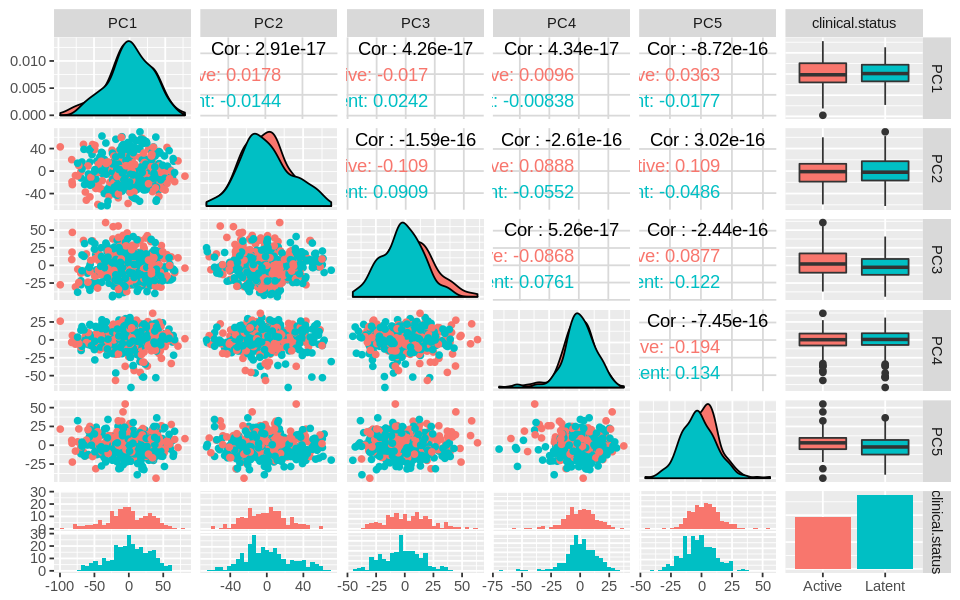

In [32]:
print(ggpairs(gg.PCA.monkey.disease, aes(colour = clinical.status)))

##### PCA of all post-infection time periods active vs latent

Result: Still basically no difference between active and latent disease

In [34]:
gg.PCA.monkey.infect.disease = as.data.frame(PCA.monkey_infect$x[,1:5])
gg.PCA.monkey.infect.disease$clinical.status = pheno[pheno$time.period != "pre.infect",]$clinical.status

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


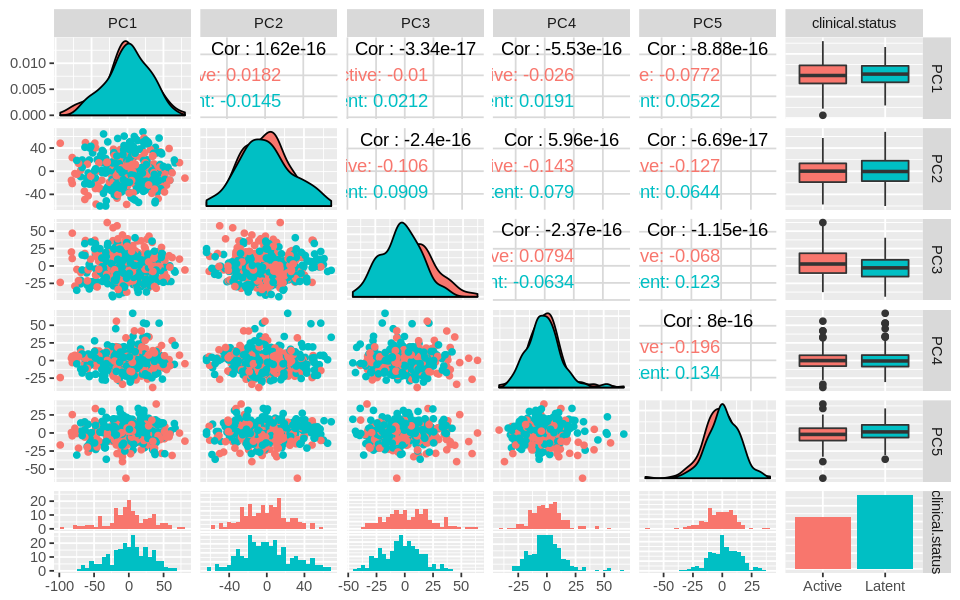

In [36]:
print(ggpairs(gg.PCA.monkey.infect.disease, aes(colour = clinical.status)))

##### PCA of all post-infection time periods individually comparing active vs latent

Result: Maybe some on PC-2,3 in late infection and a little with PC-3,5 in middle infection but overall no real separation between active and latent disease within a given time period post-infection via PCA analysis

In [37]:
m_early = monkey_var_genes[, pheno$time.period %in% c("early")]
m_middle = monkey_var_genes[, pheno$time.period %in% c("middle")]
m_late = monkey_var_genes[, pheno$time.period %in% c("late")]


PCA.monkey_early = prcomp(t(m_early), scale.=T)
PCA.monkey_middle = prcomp(t(m_middle), scale.=T)
PCA.monkey_late = prcomp(t(m_late), scale.=T)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


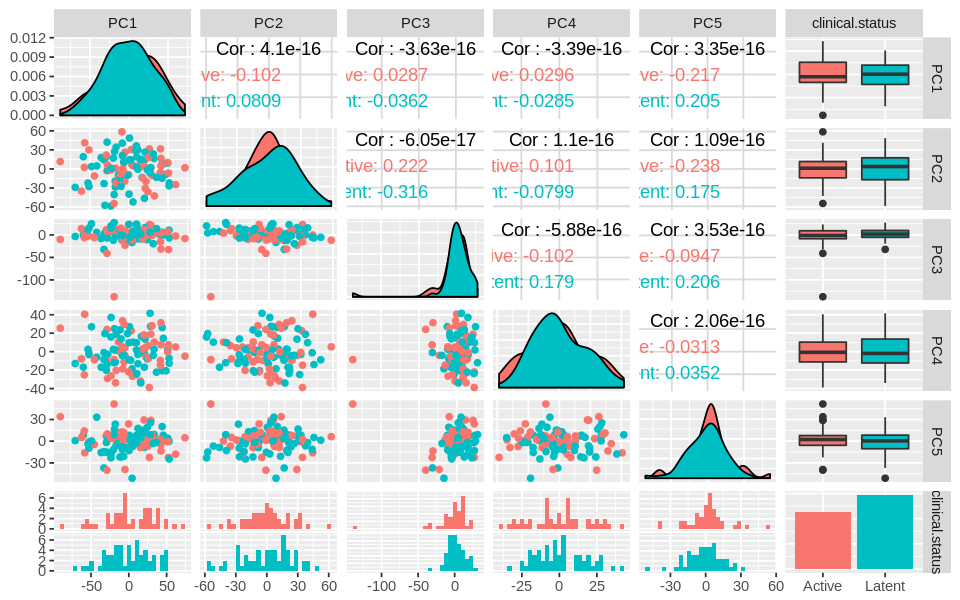

In [38]:
gg.PCA.monkey.early.disease = as.data.frame(PCA.monkey_early$x[,1:5])
gg.PCA.monkey.early.disease$clinical.status = pheno[pheno$time.period == "early",]$clinical.status
print(ggpairs(gg.PCA.monkey.early.disease, aes(colour = clinical.status)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


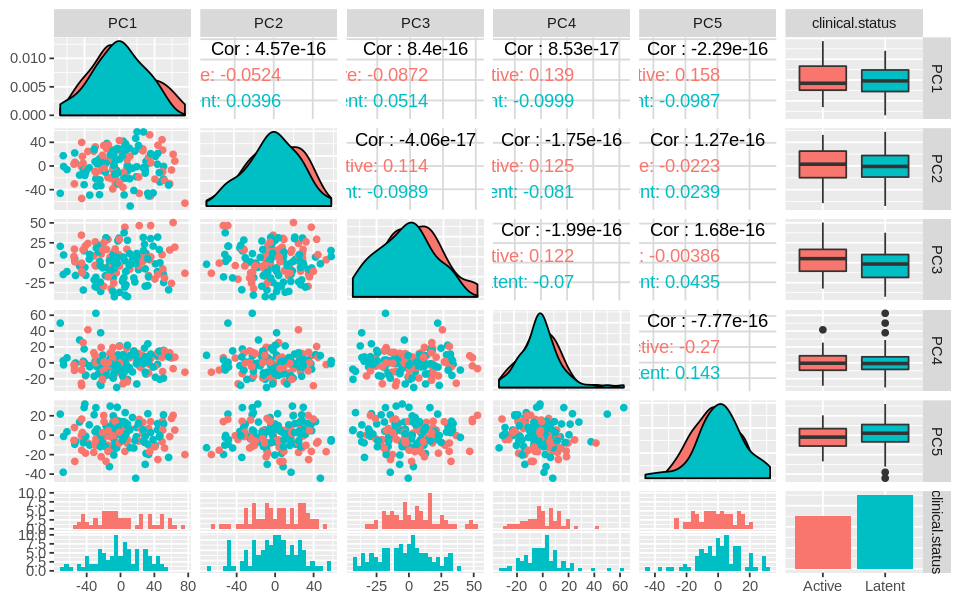

In [39]:
gg.PCA.monkey.middle.disease = as.data.frame(PCA.monkey_middle$x[,1:5])
gg.PCA.monkey.middle.disease$clinical.status = pheno[pheno$time.period == "middle",]$clinical.status
print(ggpairs(gg.PCA.monkey.middle.disease, aes(colour = clinical.status)))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


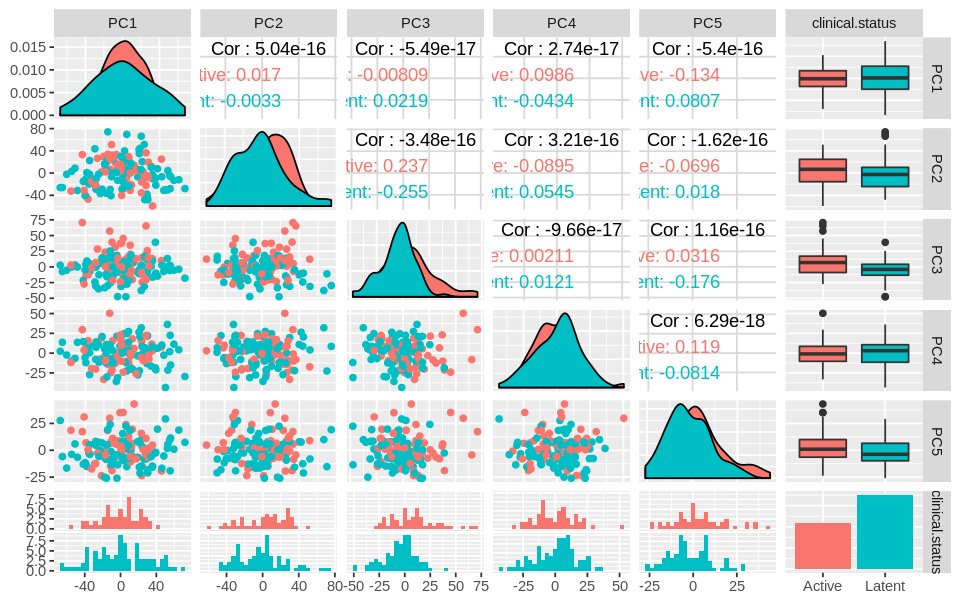

In [40]:
gg.PCA.monkey.late.disease = as.data.frame(PCA.monkey_late$x[,1:5])
gg.PCA.monkey.late.disease$clinical.status = pheno[pheno$time.period == "late",]$clinical.status
print(ggpairs(gg.PCA.monkey.late.disease, aes(colour = clinical.status)))

#### Load the classification results from my El Paso poster and confirm that the model which separates middle from late infection does not separate active and latent disease 

#### Run a caret optimization for regression using several techniques. Also include xgboost if I can. Graph the results similar to classification